<center>
    <h2>
        <font color = 'grey'> Grupo de Estudos Críticos em Infraestruturas Digitais, Artes e Inteligência Artificial </font>
    </h2>
    <h1>
        Exploring results on Google Translate experiment
    </h1>
    <h3>
        Author: 
        <font color = 'green'> Lucas Nunes Sequeira </font>
    </h3>
</center>

<h4>
    <font color = 'grey'> date: 05/10/2019 </font>
</h4>
    

<img src="results/front.png" alt="">

## Importing libs

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
%matplotlib inline

In [2]:
# Google Bilingual Evaluation Understudy
import nltk.translate.gleu_score as gleu

In [3]:
# To read files from our translation chain results
import json

In [4]:
from sklearn.linear_model import LinearRegression

## Functions

In [5]:
def read_json(filepath):
    '''
    
    Produces a pandas.DataFrame.
    
    Parameters:
    -----------
        filepath : string
            A string that represent the local path for json file.
            
    '''
    # read file
    file = open(filepath, 'r')
    aux_base = json.load(file)
    keys = aux_base[0].keys()
    for i, key in enumerate(keys):
        
        # starts the DataFrame
        if i == 0:
            temp = []
            for j in range(len(aux_base)):
                temp.append(aux_base[j][key])
            base = pd.DataFrame({key: temp})
            
        # append to DataFrame
        else:
            temp = []
            for j in range(len(aux_base)):
                temp.append(aux_base[j][key])
            base[key] = temp
            
    file.close()
    
    # returns the pd.DataFrame with an adition of 2 columns, 'From code' and 'From lang'.
    return FromCodeLang(base)

In [6]:
def FromCodeLang(data):
    '''
    
    Recieve a pandas.DataFrame and add to it 2 new columns, 'From code' and 'To code' according to the previews codes and corresponding languages for each row in the pandas.DataFrame.
    
    Parameters:
    -----------
        data : pandas.DataFrame
            A pandas.DataFrame that contains columns 'Code' and 'Language'.
            
    '''
    
    # collect code and languages
    codes = data['Code'].values
    langs = data['Language'].values
    
    from_codes = []
    from_langs = []
    
    # append the previews code and language for each row
    for i in range(len(codes)-1):
        from_codes.append(codes[i])
        from_langs.append(langs[i])
        
    # for the first language of the chain, repeat it self
    from_codes.insert(0, codes[0])
    from_langs.insert(0,langs[0])
    
    # add to pd.DataFrame
    data['From code'] = from_codes
    data['From lang'] = from_langs
    data.rename(columns = {'Language': 'Lang', 'Code': 'Code', 'Text_origin': 'Text origin', 'Text_en': 'Text en'}, inplace = True)
    return data

In [7]:
def RMSE(y, y_):
    '''
    
    Returns root mean square error
    
    '''
    
    return np.sqrt(((y-y_)**2).sum()/len(y))

In [8]:
def meanCorr(corr, mid = False):
    '''
    
    Returns the mean value for matrix.
    
    Parameters:
    -----------
        corr : pd.DataFrame
            pd.DataFrame with shape (n, m)
        mid : boolean
            If True, the function will exclude the pairs of repeated language.
    
    '''
    mean = corr.sum().sum()
    if mid == False:
        k = len(corr.columns)
    else:
        k = 0
    mean -= k
    mean /= (len(corr.columns) * len(corr.index) - k)
    
    return mean

In [9]:
def prepareCorr(corr, name = 'from \ to', dropEnglish = True):
    '''
    
    Returns a pd.DataFrame with index name set to be 'name' and drop or not English column
    
    Parameters:
    -----------
        corr : pd.DataFrame
            pd.DataFrame with shape (n, m)
        name : string
            name for the index
        dropEnglish : boolean
            If True, the function will exclude the English column.
    
    '''
    if dropEnglish == True:
        temp = corr.drop('English', axis = 1).reset_index()
    else:
        temp = corr.reset_index()
    temp = temp.rename({'from \ to': name}, axis = 1)
    temp = temp.set_index(name)
    return temp.copy()

## Classes

In [10]:
class Result:
    '''
    
    Create a Result class, that have some cool stuf built especific, as plots.
    
    Parameters:
    -----------
        filepath : string
            A string that represent the local path for json file.
        n : uint
            Especify the first n rows of pd.DataFrame to read.
        graphpap : boolean
            If True, it create a correlation matrix with corresponding gleu score for each translation pair.
        
    Atributes:
    -----------
        df_ : pd.DataFrame
            The pd.DataFrame read from results.
        sz_ : int
            The size of df_
        graph_pap_ : pd.DataFrame
            Correlation matrix of gleu score of each pair of language
        self.acc_harmonic_ : array
            The theorical curve that aproximates to GLEU acc empirichal results
        self.acc_alpha_ : float
            The divergence factor which describes acc_harmonic_
        self.acc_erro_ : array
            RMSE for each t between GLEU acc and acc_harmonic_
        self.sz_harmonic_ : array
            The theorical curve that aproximates to sz empirichal results
        self.sz_alpha_ : float
            The divergence factor which describes sz_harmonic_
        self.sz_erro_ : array
            RMSE for each t between size and sz_harmonic_
            
    '''
    
    def __init__(self, filepath, n = None, graphpap = False):
        self.df_ = read_json(filepath)
        if n is not None:
            self.df_ = self.df_.head(n)
        self.sz_ = len(self.df_)
        self.graph_pap_ = None
        self.acc_harmonic_ = None
        self.sz_harmonic_ = None
        self.acc_alpha_ = None
        self.sz_alpha_ = None
        self.acc_erro_ = None
        self.sz_erro_ = None
        self.prepare(graphpap)
        
    def getPair(self, fromV, toV, kind = 'Code'):
        '''
    
        Return a pd.DataFrame that have all the pair of 'from value' and 'to value', wich value can be 'language' or 'code'.

        Parameters:
        -----------
            fromV : string
                A string that represent the 'from value'.
            toV : string
                A string that represent the 'to value'.
            kind : string
                especify the kind of value. Can be 'Code' or 'Lang'.
           
        '''
        if kind == 'Code':
            temp = self.df_[self.df_['From code'] == fromV]
            return temp[temp['Code'] == toV]
        else:
            temp = self.df_[self.df_['From lang'] == fromV]
            return temp[temp['Lang'] == toV]
        
    def addGLEUacc(self):
        '''
    
        Adds to df_ a 'GLEU acc' column that contains the acumulative score, by comparing each english version of the translation chain with the original text also in english.

           
        '''
        # original text in english as reference
        reference = self.df_['Text en'][0]
        
        # first score set to be 1.0 (comparing same languages)
        temp = [1.0]
        for hypothesis in self.df_['Text en'][1:]:
            
            # take the gleu score
            gleu_value = gleu.sentence_gleu([reference], hypothesis)
            
            temp.append(gleu_value)
        
        # add to df_
        self.df_['GLEU acc'] = temp
        
        del temp
        
    def addGLEUpap(self):
        '''
    
        Adds to df_ a 'GLEU pap' column that contains the step to step score, by comparing each english version of the translation chain with the previews text also in english.

           
        '''
        # first reference
        reference = self.df_['Text en'][0]
        
        # first score set to be 1.0 (comparing same languages)
        temp = [1.0]
        for i, hypothesis in enumerate(self.df_['Text en'][1:]):
            # take the gleu score
            gleu_value = gleu.sentence_gleu([reference], hypothesis)
            temp.append(gleu_value)
            
            # change reference
            reference = hypothesis
        self.df_['GLEU pap'] = temp
        del temp
        
    def addSizes(self):
        '''
        
        Adds to df_ a 'Size' column that contains for each text in english, it word count.
        
        '''
        self.df_['Size'] = self.df_['Text en'].apply(lambda x : len(x.split()))
    
    def addHarmonic(self):
        '''
        
        Calculates the best harmonic function for Size and GLEU acc my minimizing RMSE. Also record the alpha used for each case, and the RMSE.
        
        '''
        # calculating for GLEU acc
        best_alpha = 0
        best_erro = 999999999
        scores = self.df_['GLEU acc']
        x = np.arange(len(scores))
        
        # finding minimum error
        for alpha in np.linspace(0,5,500):
            y = (x+1)**(-alpha)
            erro = RMSE(y, scores)
            if erro < best_erro:
                best_erro = erro
                best_alpha = alpha
                
        self.acc_harmonic_ = (x+1)**(-best_alpha)
        self.acc_alpha_ = best_alpha
        self.acc_erro_ = best_erro
        
        # calculating for Size
        best_alpha = 0
        best_erro = 999999999
        scores = self.df_['Size']
        x = np.arange(len(scores))
        
        # finding minimum error
        for alpha in np.linspace(0,5,500):
            y = scores[0]*(x+1)**(-alpha)
            erro = RMSE(y, scores)
            if erro < best_erro:
                best_erro = erro
                best_alpha = alpha
                
        self.sz_harmonic_ = scores[0]*(x+1)**(-best_alpha)
        self.sz_alpha_ = best_alpha
        self.sz_erro_ = best_erro
        
        
        
    def graphGLEUpap(self):
        '''
        
        Constructs a directioned graph as a matrix of GLEU step by step (pap) for each pair of language
        
        '''
        
        temp = {'from \ to': self.df_['Lang'].unique()}
        temp = pd.DataFrame(temp)
        for lang in self.df_['Lang'].unique():
            aux = pd.DataFrame({lang : temp['from \ to'].apply(lambda x : self.getPair(x, lang, kind = 'Lang')['GLEU pap'].mean())})
            temp = pd.concat([temp, aux], axis = 1)
        self.graph_pap_ = temp.set_index('from \ to', drop = True)
        for lang in self.df_['Lang'].unique():
            self.graph_pap_.loc[lang][lang] = 1.0
        del temp
        
    def prepare(self, graphpap):
        '''
        
        Prepare the object performing some methods as addGLEUacc, addGLEUpap, addSizes, addHarmonic and graphGLEUpap.
        
        Parameters:
        -----------
            graphpap: boolean
                if True, the method perform graphGLEUpap()
        
        '''
        
        self.addGLEUacc()
        self.addGLEUpap()
        self.addSizes()
        self.addHarmonic()
        if graphpap:
            self.graphGLEUpap()

In [107]:
class Results:
    
    def __init__(self, results = None, names = None, graphpap = False):
        self.res = {}
        if results is not None:
            for i in range(len(names)):
                self.addResult(results[i], names[i])
        self.graph_pap_ = None
        self.acc_mean_ = None
        self.acc_harmonic_ = None
        self.acc_alpha_ = None
        self.acc_erro_ = None
        self.sz_mean_ = None
        self.sz_harmonic_ = None
        self.sz_alpha_ = None
        self.sz_erro_ = None
        self.prepare(graphpap)
        
        
    def addResult(self, result, name):
        self.res[name] = result
        
    def addHarmonic(self):
        best_alpha = 0
        best_erro = 999999999
        scores = self.acc_mean_
        x = np.arange(len(scores))
        for alpha in np.linspace(0,5,500):
            y = (x+1)**(-alpha)
            erro = RMSE(y, scores)
            if erro < best_erro:
                best_erro = erro
                best_alpha = alpha
        self.acc_harmonic_ = (x+1)**(-best_alpha)
        self.acc_alpha_ = best_alpha
        self.acc_erro_ = best_erro
        
        best_alpha = 0
        best_erro = 999999999
        scores = self.sz_mean_
        x = np.arange(len(scores))
        for alpha in np.linspace(0,5,500):
            y = scores[0]*(x+1)**(-alpha)
            erro = RMSE(y, scores)
            if erro < best_erro:
                best_erro = erro
                best_alpha = alpha
        self.sz_harmonic_ = scores[0]*(x+1)**(-best_alpha)
        self.sz_alpha_ = best_alpha
        self.sz_erro_ = best_erro
        
    def prepare(self, pap):
        if pap:
            self.graphGLEUpap()
            
        # gleu acc mean; and sz mean
        n = self.res[list(self.res.keys())[0]].sz_
        self.acc_mean_ = np.zeros(n)
        self.sz_mean_ = np.zeros(n)
        
        for name in self.res.keys():
            self.acc_mean_ += self.res[name].df_['GLEU acc']
            self.sz_mean_ += self.res[name].df_['Size']
            
        self.acc_mean_ /= len(self.res.keys())
        self.acc_mean_ = self.acc_mean_.values
        
        self.sz_mean_ /= len(self.res.keys())
        self.sz_mean_ = self.sz_mean_.values
        
        # addHarmonic
        
        self.addHarmonic()
        
    def graphGLEUpap(self):
        print(self.res.keys())
        self.graph_pap_ = self.res[list(self.res.keys())[0]].graph_pap_.copy()
        for flang in self.graph_pap_.index:
            for tlang in self.graph_pap_.index:
                temp = []
                count = 0
                for name in self.res.keys():
                    value = self.res[name].graph_pap_.loc[flang][tlang]
                    if not np.isnan(value):
                        temp.append(value)
                        count += 1
                if count == 0:
                    temp = np.nan
                    self.graph_pap_.loc[flang][tlang] = temp
                else:
                    temp = np.array(temp).mean()
                    self.graph_pap_.loc[flang][tlang] = temp/count
        
    
    def plot(self, by, lw = 3, showAll = True, showMean = True,
             fillBetween = False, showHarmonic = False, ylabel = 'score',
             title = None, alphaAll = 0.5):
        plt.figure(figsize=(14,8))
        
        if title == None:
            title = by
        
        # mean
        mean = None
        if by == 'GLEU acc':
            mean = self.acc_mean_
        if by == 'Size':
            mean = self.sz_mean_
            
        n = self.res[list(self.res.keys())[0]].sz_
        erro = np.zeros(n)
        for name in self.res.keys():
            if showAll:
                plt.plot(self.res[name].df_[by], lw = lw, label = name, alpha = alphaAll)
                
        if fillBetween:
            for name in self.res.keys():
                erro += (self.res[name].df_[by].values - mean)**2
            erro /= len(self.res.keys())
            erro = np.sqrt(erro)
            x = np.arange(n)
            plt.fill_between(x, mean, mean + erro, color = 'firebrick', alpha = 0.5, label = 'mean confiance')
            plt.fill_between(x, mean, mean - erro, color = 'firebrick', alpha = 0.5)
            
        if showMean:
            plt.plot(mean, '-', lw = 3, label = 'mean', color = 'red')
        if showHarmonic:
            if by == 'GLEU acc':
                print('>> alpha: {0:1.5f}'.format(self.acc_alpha_))
                plt.plot(self.acc_harmonic_, '--', lw = lw, label = 'harmonic', color = 'purple')
            else:
                print('>> alpha: {0:1.5f}'.format(self.sz_alpha_))
                plt.plot(self.sz_harmonic_, '--', lw = lw, label = 'harmonic', color = 'purple')
  
        plt.title(title)
        plt.xlabel('# traduction')
        plt.ylabel(ylabel)
        plt.legend()
        
        return mean
    
    def plotRegression(self, by, lw = 3):
        plt.figure(figsize=(14,8))
        x = np.arange(len(self.acc_harmonic_), dtype = float)
        if by == 'GLEU acc':
            print('>> alpha:', self.acc_alpha_)
            mean_ = self.acc_mean_*(x+1)**(self.acc_alpha_+1)
        else:
            print('>> alpha:', self.sz_alpha_)
            mean_ = self.sz_mean_*(x+1)**(self.sz_alpha_+1)
        reg = LinearRegression()
        reg.fit(x.reshape(-1,1), mean_)
        y = reg.predict(x.reshape(-1,1))
        plt.plot(mean_, lw = lw, label = 'mean', color = 'navy')
        plt.plot(y, '--', lw = lw, label = 'regression', color = 'deeppink')            
        plt.title(by+r' | $R^2$ = {0:1.5f} | Harmonic approach'.format(reg.score(x.reshape(-1,1), mean_.reshape(-1,1))))
        plt.xlabel(r'# traduction $[t]$')
        plt.ylabel(r'mean $\times (t+1)^{\alpha + 1}$')
        plt.legend()

        return mean
    
    def plotLogLog(self, by, lw = 1, ms = 5):
        plt.figure(figsize=(14,8))
        if by == 'GLEU acc':
            plt.loglog(self.acc_mean_, 'o--', lw = lw, color = 'purple', label = 'mean', markersize = ms, markerfacecolor = 'deeppink')
        if by == 'Size':
            plt.loglog(self.sz_mean_, 'o--', lw = lw, color = 'purple', label = 'mean', markersize = ms, markerfacecolor = 'deeppink')
        plt.title(by+' | loglog Visualization')
        plt.xlabel(r'$\log$ traduction $[\log(t)]$')
        plt.ylabel(r'$\log$ mean')
        plt.legend()
        
        return mean

## Exploring b1, b2, b3, t1, t2 experiments

In [108]:
%%time

b1_t1 = Result('results/b1_t1.json')
b1_t2 = Result('results/b1_t2.json')
b2_t1 = Result('results/b2_t1.json')
b2_t2 = Result('results/b2_t2.json')
b3_t1 = Result('results/b3_t1.json')
b3_t2 = Result('results/b3_t2.json')

results = [b1_t1, b2_t1, b3_t1, b1_t2, b2_t2, b3_t2]
names = ['b1_t1', 'b2_t1', 'b3_t1', 'b1_t2', 'b2_t2', 'b3_t2']

res = Results(results, names)

res1 = Results(results[:3], names[:3])
res2 = Results(results[3:], names[3:])

CPU times: user 6.16 s, sys: 3.99 ms, total: 6.17 s
Wall time: 6.21 s


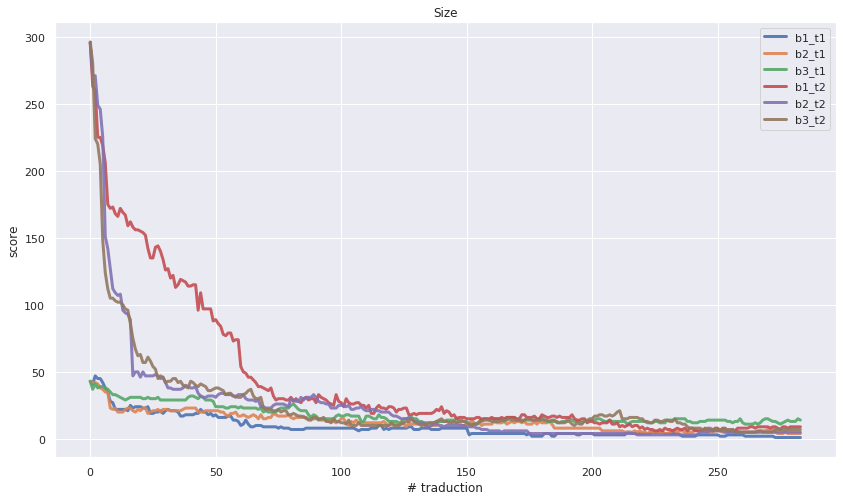

In [47]:
_ = res.plot('Size', fillBetween=False, showAll = True, showMean = False, alphaAll = 0.9)

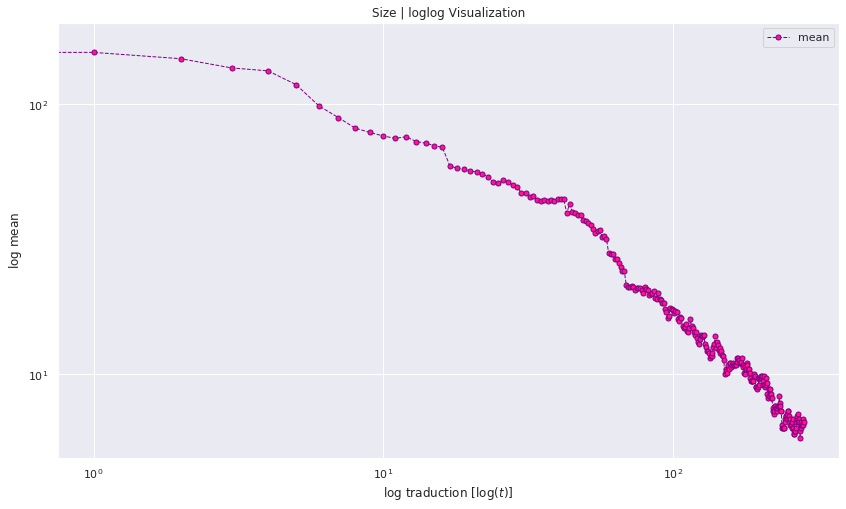

In [111]:
mean = res.plotLogLog('Size')

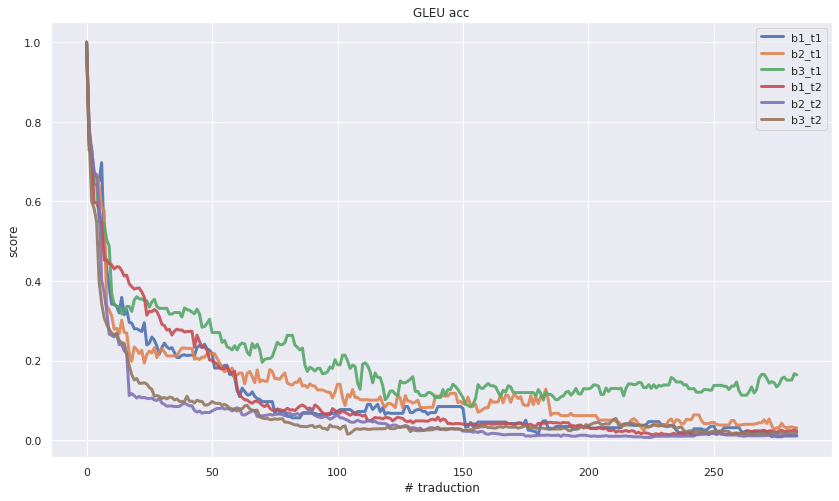

In [48]:
mean = res.plot('GLEU acc', fillBetween=False, showAll = True, showMean = False, alphaAll = 0.9)

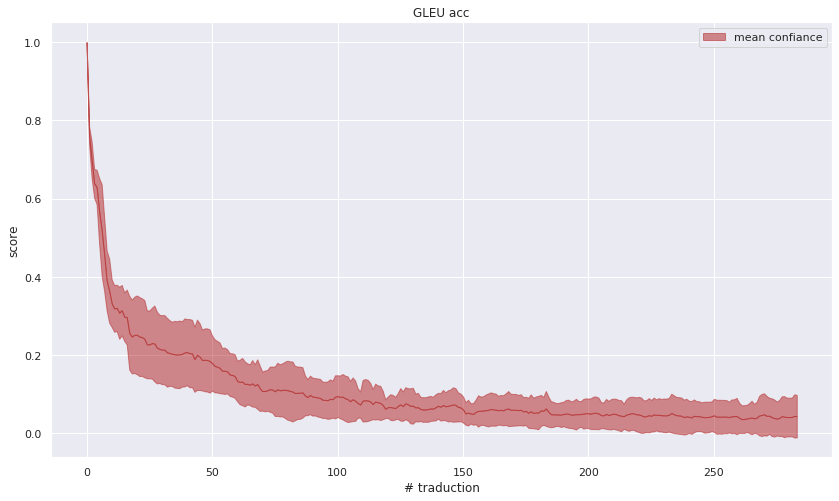

In [49]:
mean = res.plot('GLEU acc', fillBetween=True, showAll = False, showMean = False, alphaAll = 0.9)

>> alpha: 0.49098


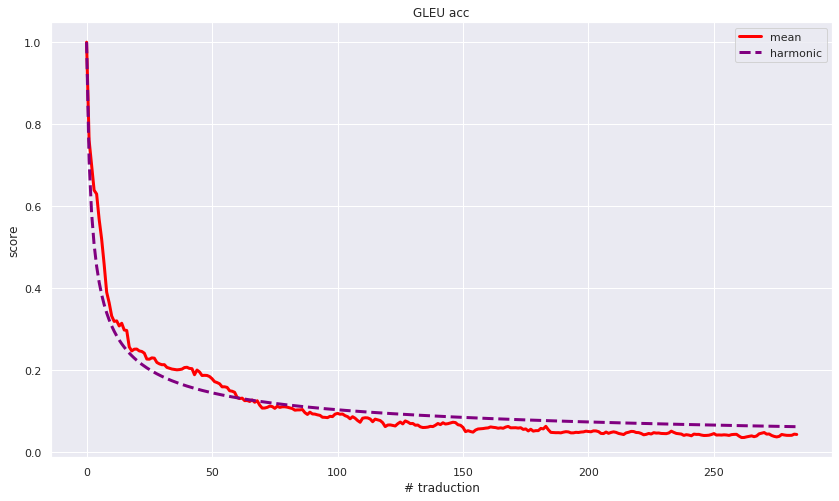

In [50]:
mean = res.plot('GLEU acc', fillBetween=False, showAll = False, showHarmonic = True)

>> alpha: 0.4909819639278557


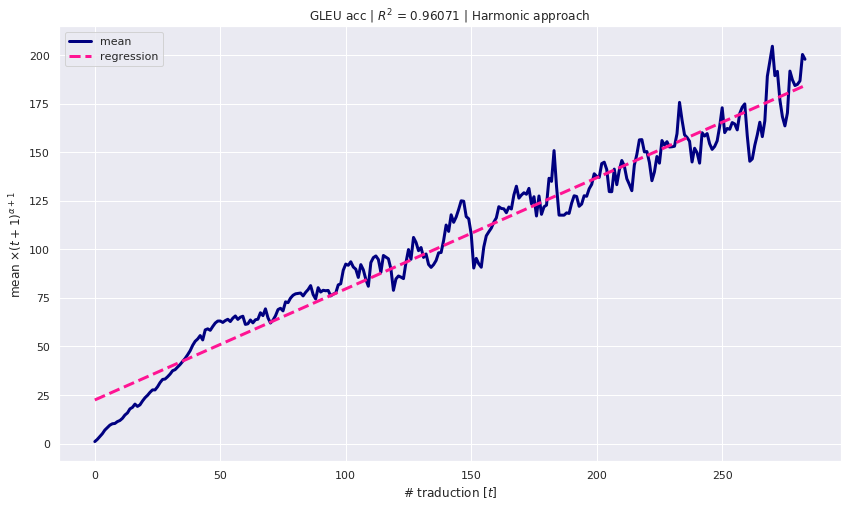

In [17]:
mean = res.plotRegression('GLEU acc')

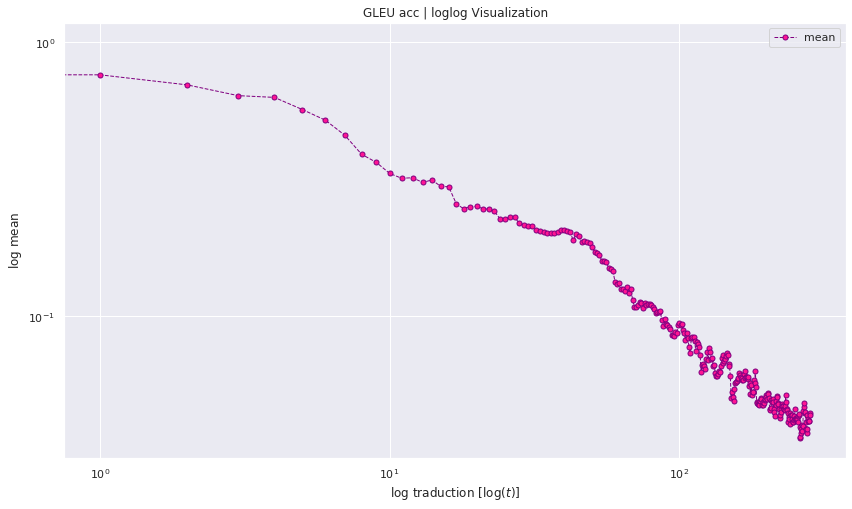

In [110]:
mean = res.plotLogLog('GLEU acc')

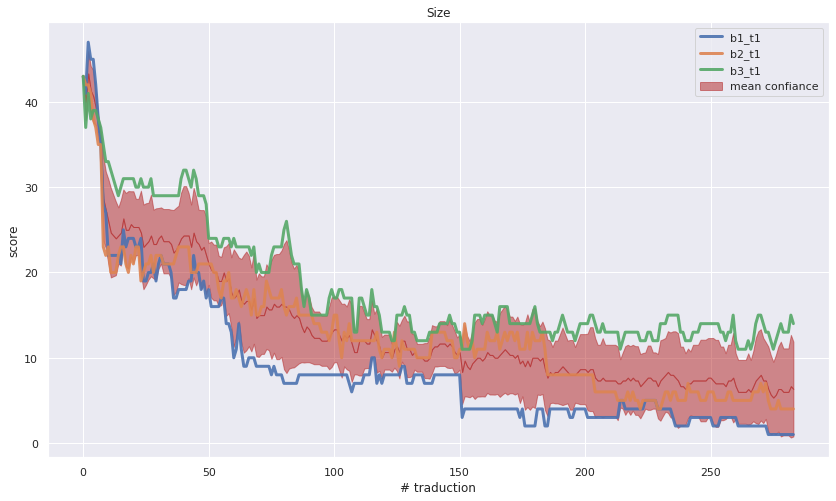

In [53]:
mean = res1.plot('Size', fillBetween=True, showAll = True, showMean = False, alphaAll = 0.9)

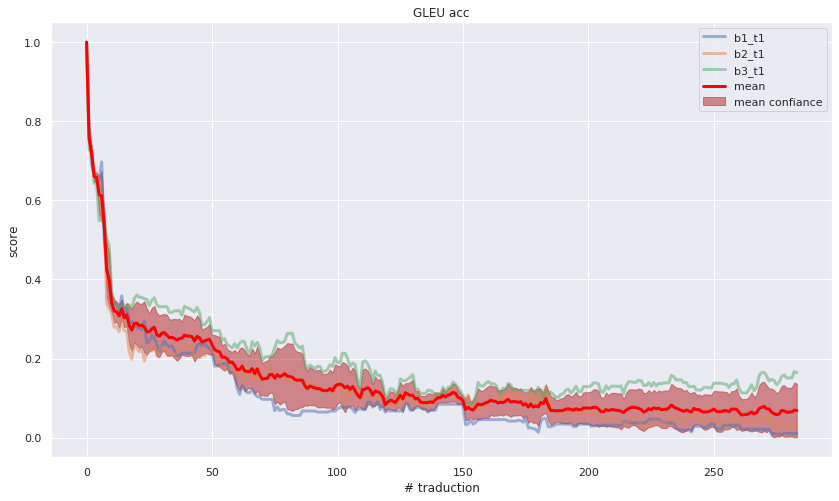

In [55]:
mean = res1.plot('GLEU acc', fillBetween=True, showAll = True)

>> alpha: 0.44088


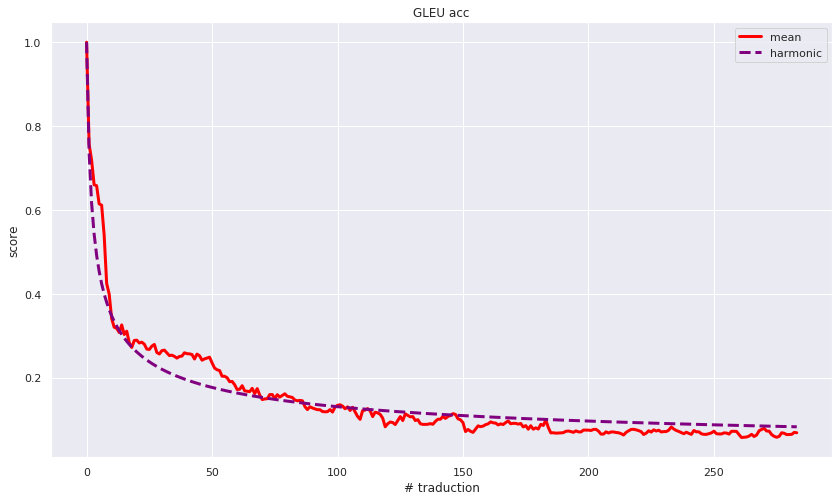

In [20]:
mean = res1.plot('GLEU acc', fillBetween=False, showAll = False, showHarmonic = True)

>> alpha: 0.4408817635270541


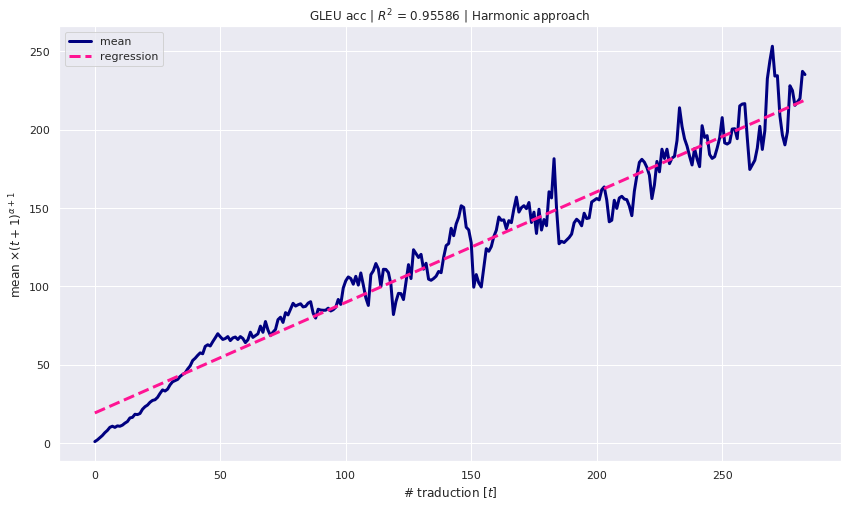

In [57]:
mean = res1.plotRegression('GLEU acc')

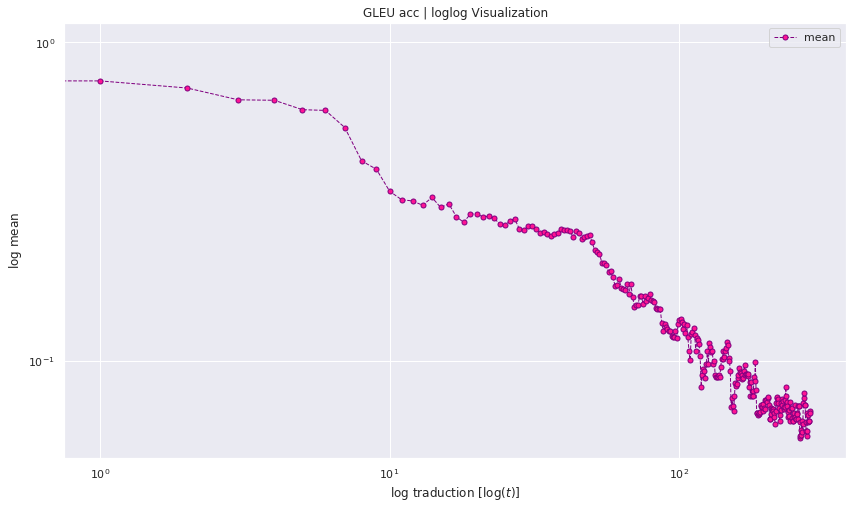

In [101]:
mean = res1.plotLogLog('GLEU acc')

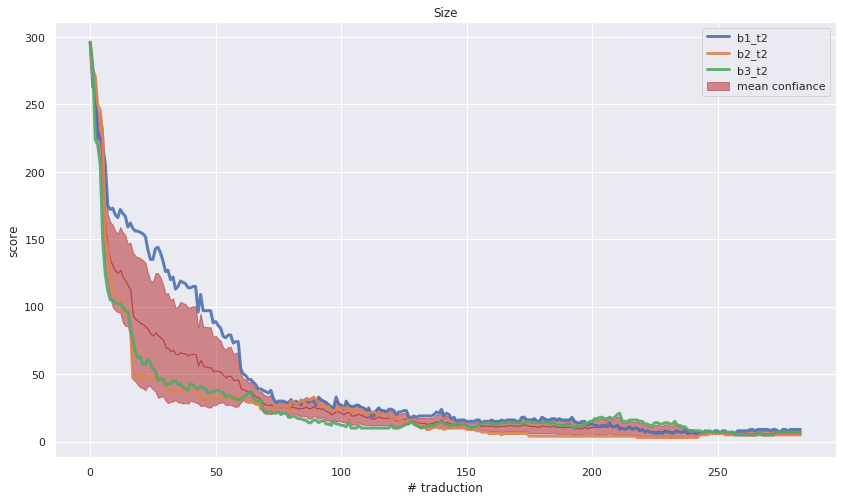

In [22]:
_ = res2.plot('Size', fillBetween=True, showAll = True, showMean = False, alphaAll = 0.9)

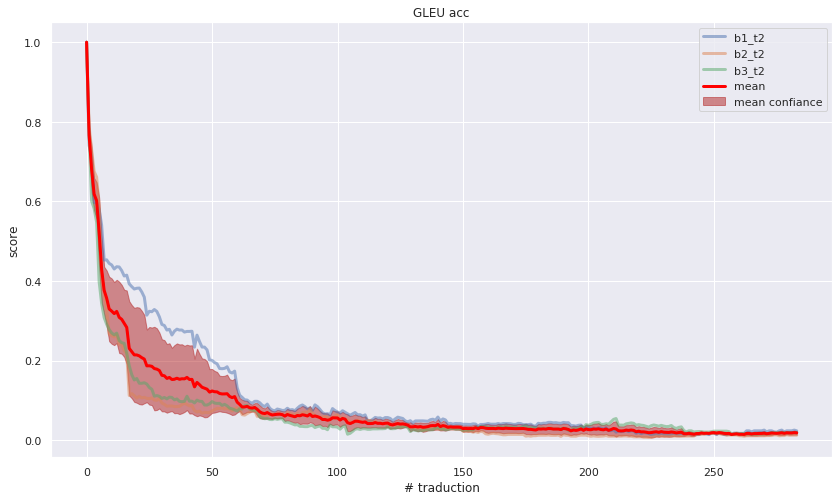

In [23]:
mean = res2.plot('GLEU acc', fillBetween=True, showAll = True)

>> alpha: 0.57114


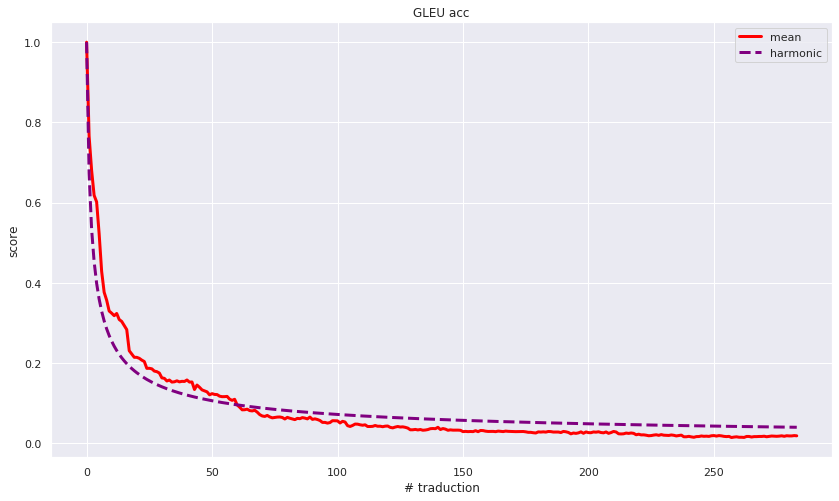

In [24]:
mean = res2.plot('GLEU acc', fillBetween=False, showAll = False, showHarmonic = True)

>> alpha: 0.5711422845691383


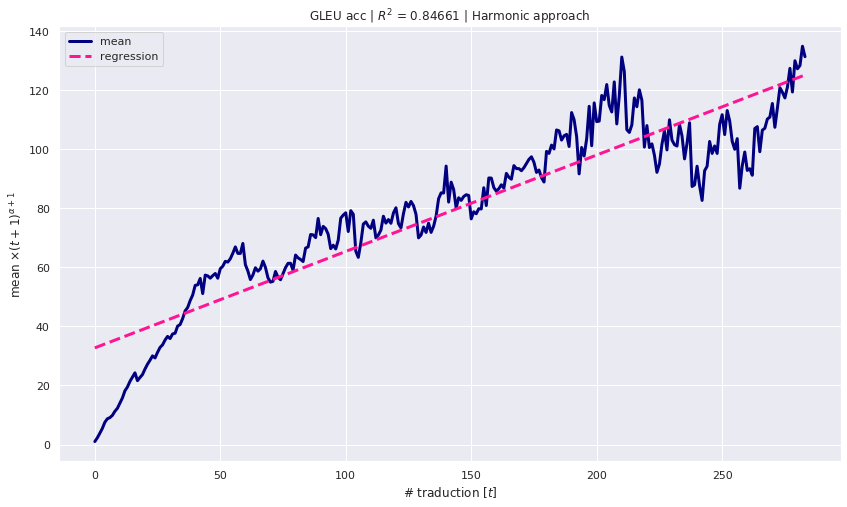

In [59]:
mean = res2.plotRegression('GLEU acc')

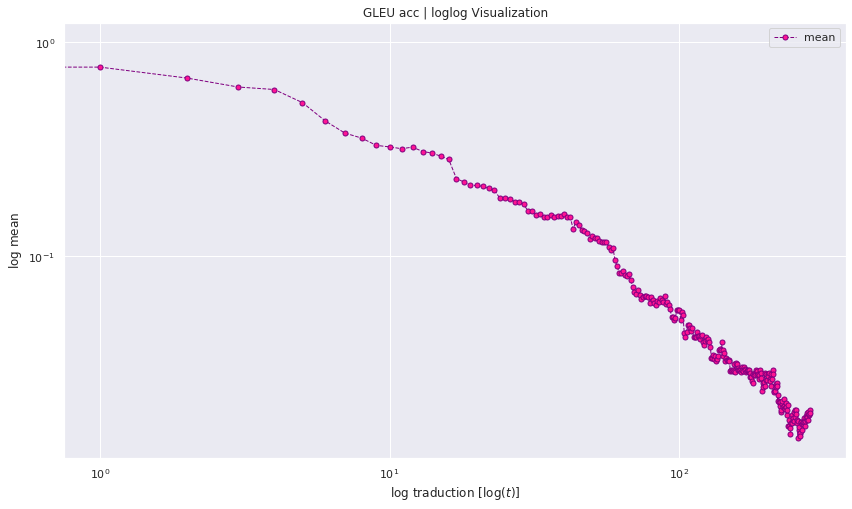

In [100]:
mean = res2.plotLogLog('GLEU acc')

## Exploring l1, l2, m1, m2, t1 experiments

In [96]:
%%time

l1_t1 = Result('results/l1_t1.json', graphpap=True)
l2_t1 = Result('results/l2_t1.json', graphpap=True)
m1_t1 = Result('results/m1_t1.json', graphpap=True)
m2_t1 = Result('results/m2_t1.json', graphpap=True)

results = [l1_t1, l2_t1, m1_t1, m2_t1]
names = ['l1_t1', 'l2_t1', 'm1_t1', 'm2_t1']

res_l_m = Results(results, names)
res_l = Results(results[:2], names[:2])
res_m = Results(results[2:], names[2:])

CPU times: user 3.26 s, sys: 3.98 ms, total: 3.26 s
Wall time: 3.27 s


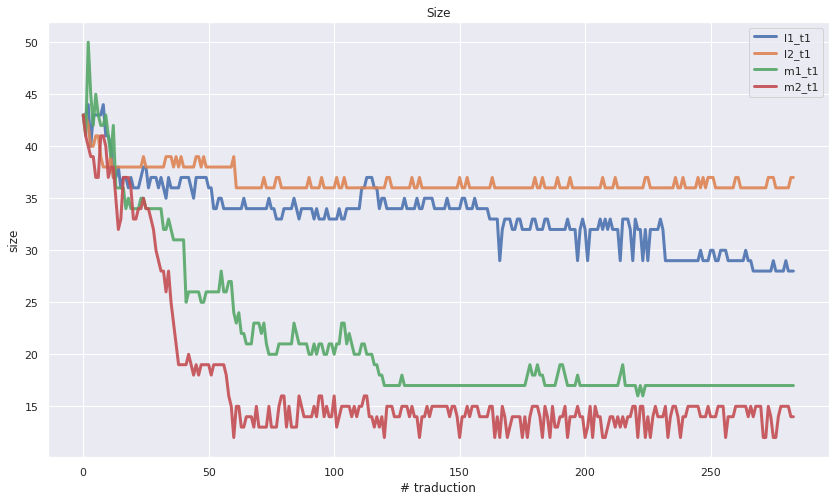

In [27]:
mean = res_l_m.plot('Size', fillBetween=False, showAll = True, showHarmonic = False, showMean = False, alphaAll = 0.9, ylabel = 'size')

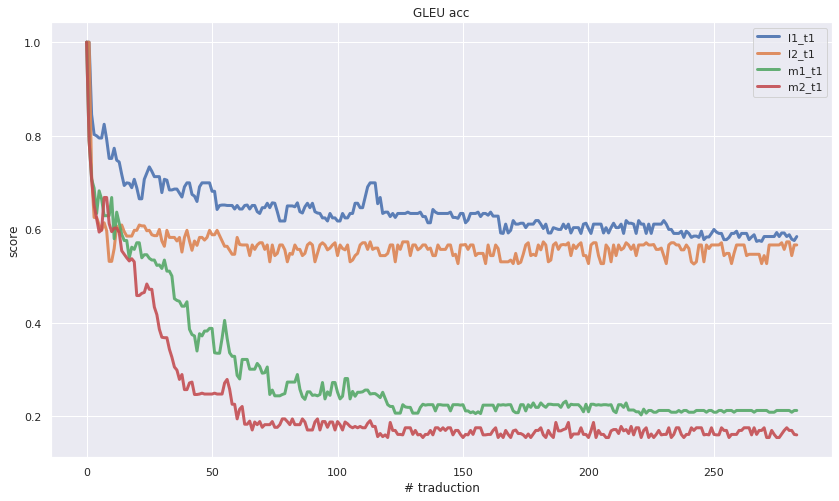

In [28]:
mean = res_l_m.plot('GLEU acc', fillBetween=False, showAll = True, showHarmonic = False, showMean = False, alphaAll = 0.9)

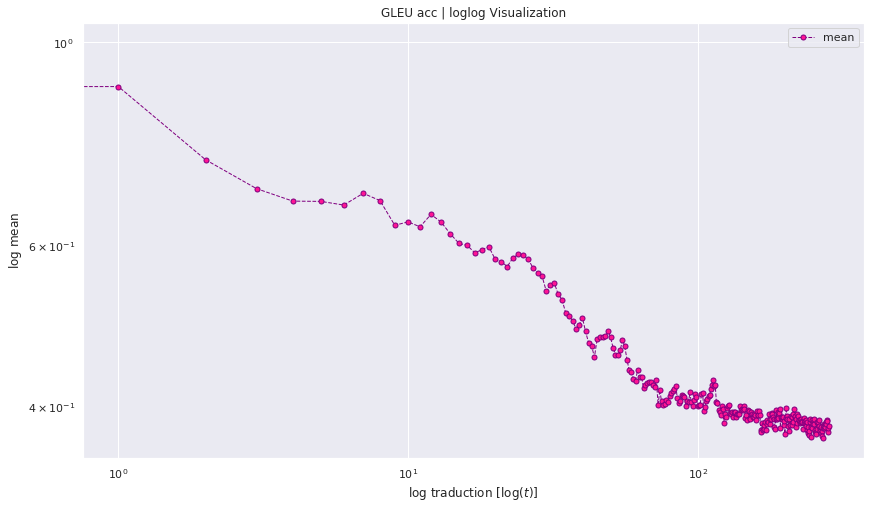

In [98]:
mean = res_l_m.plotLogLog('GLEU acc')

>> alpha: 0.11022


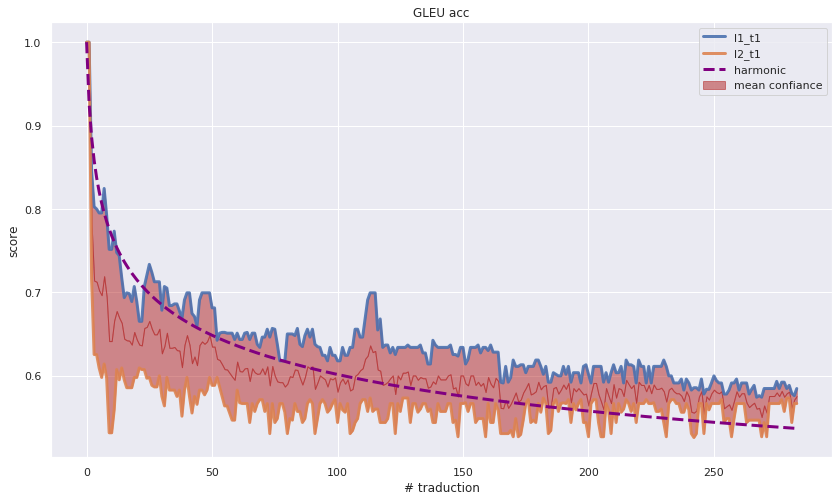

In [61]:
mean = res_l.plot('GLEU acc', fillBetween=True, showAll = True, showHarmonic = True, showMean = False, alphaAll = 0.9)

>> alpha: 0.11022044088176353


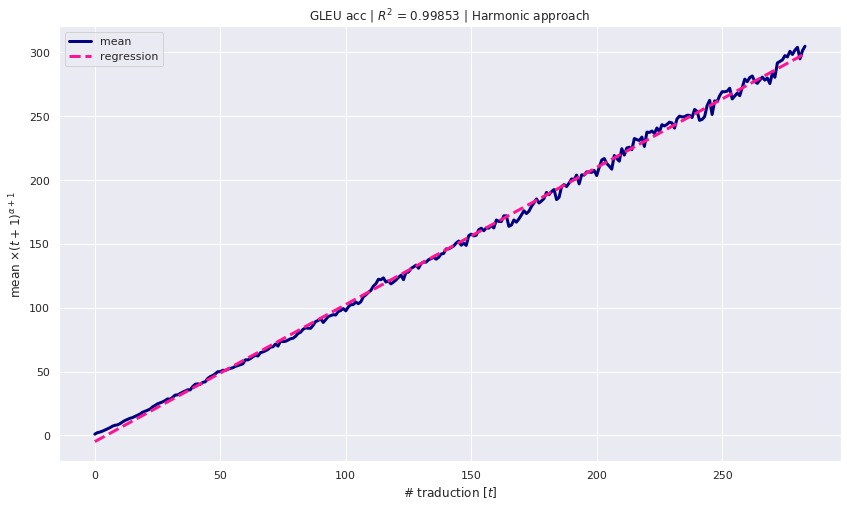

In [30]:
_ = res_l.plotRegression('GLEU acc')

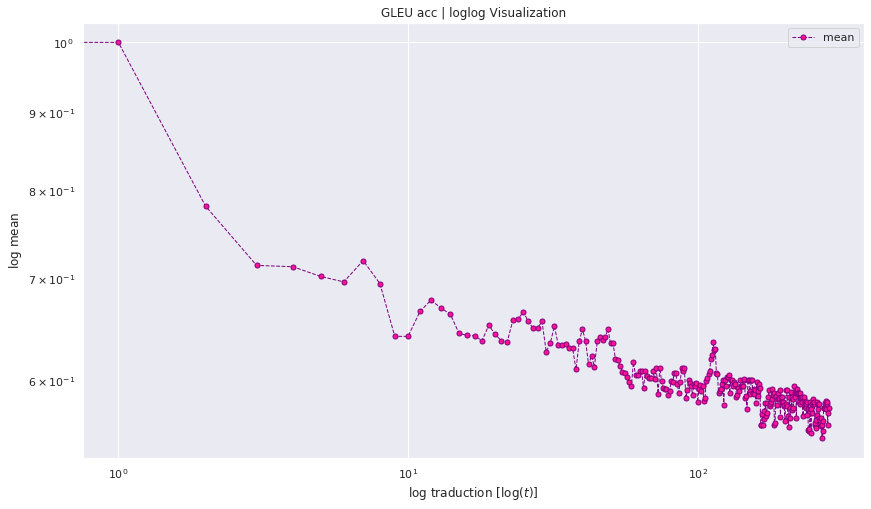

In [97]:
mean = res_l.plotLogLog('GLEU acc')

>> alpha: 0.30060


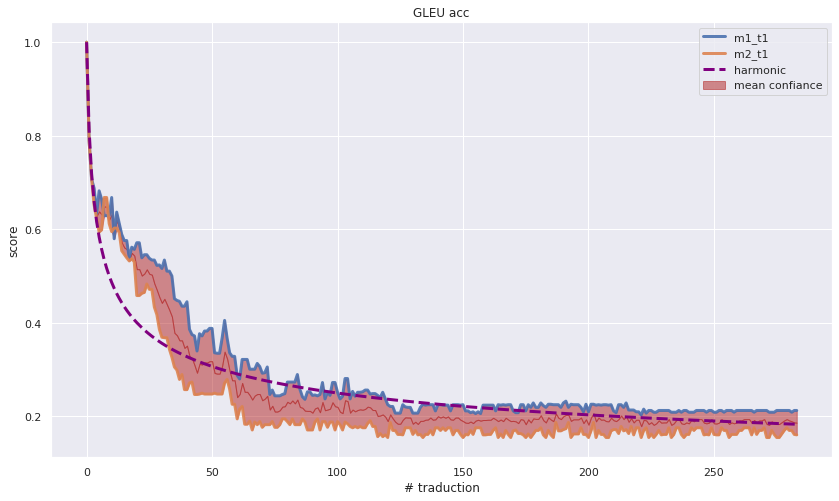

In [63]:
mean = res_m.plot('GLEU acc', fillBetween=True, showAll = True, showHarmonic = True, showMean = False, alphaAll = 0.9)

>> alpha: 0.3006012024048096


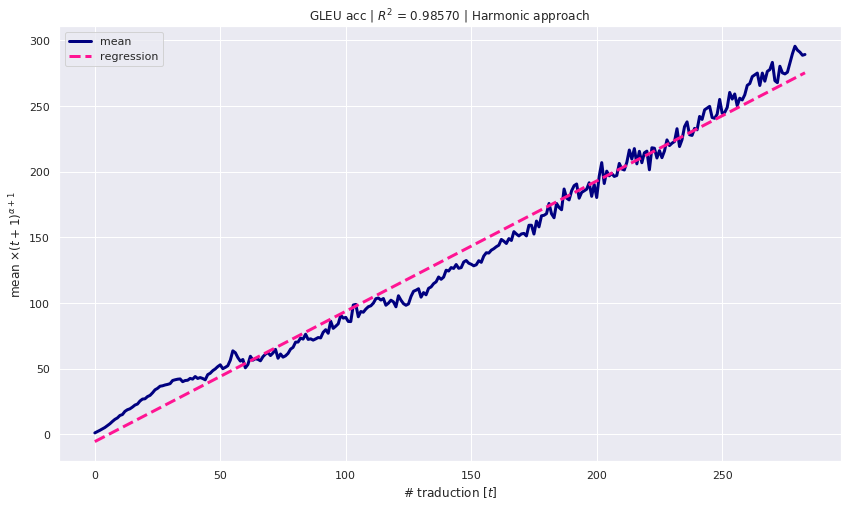

In [32]:
_ = res_m.plotRegression('GLEU acc')

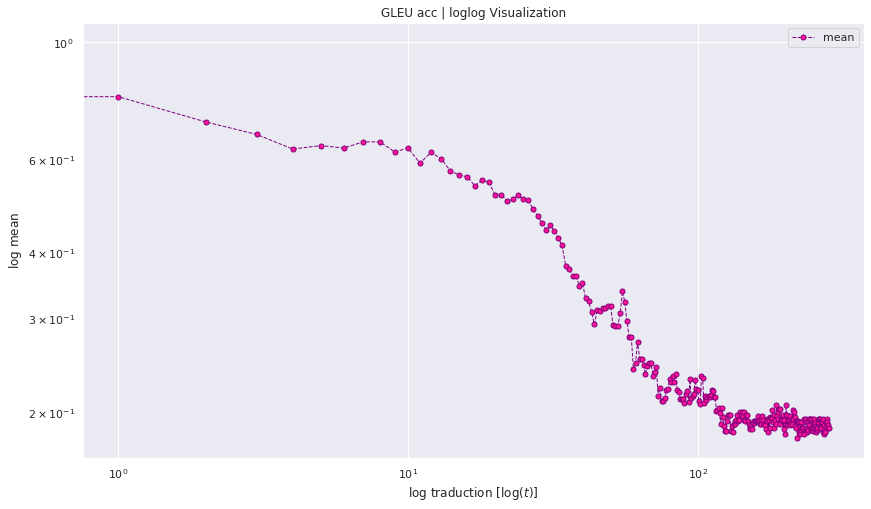

In [99]:
mean = res_m.plotLogLog('GLEU acc')

In [33]:
auxl1 = res_l_m.res['l1_t1'].graph_pap_.copy()
auxl2 = res_l_m.res['l2_t1'].graph_pap_.copy()
auxm1 = res_l_m.res['m1_t1'].graph_pap_.copy()
auxm2 = res_l_m.res['m2_t1'].graph_pap_.copy()

auxl2 = auxl2.drop('Portuguese', axis = 1)
auxl2 = auxl2.drop('Portuguese', axis = 0)
auxm2 = auxm2.drop('Portuguese', axis = 1)
auxm2 = auxm2.drop('Portuguese', axis = 0)

In [34]:
auxl1 = prepareCorr(auxl1, 'l1')
auxl2 = prepareCorr(auxl2, 'l2')
auxm1 = prepareCorr(auxm1, 'm1')
auxm2 = prepareCorr(auxm2, 'm2')

Mean Scores:
>> l1: 0.9503
>> l2: 0.9332
>> m1: 0.9085
>> m2: 0.8780


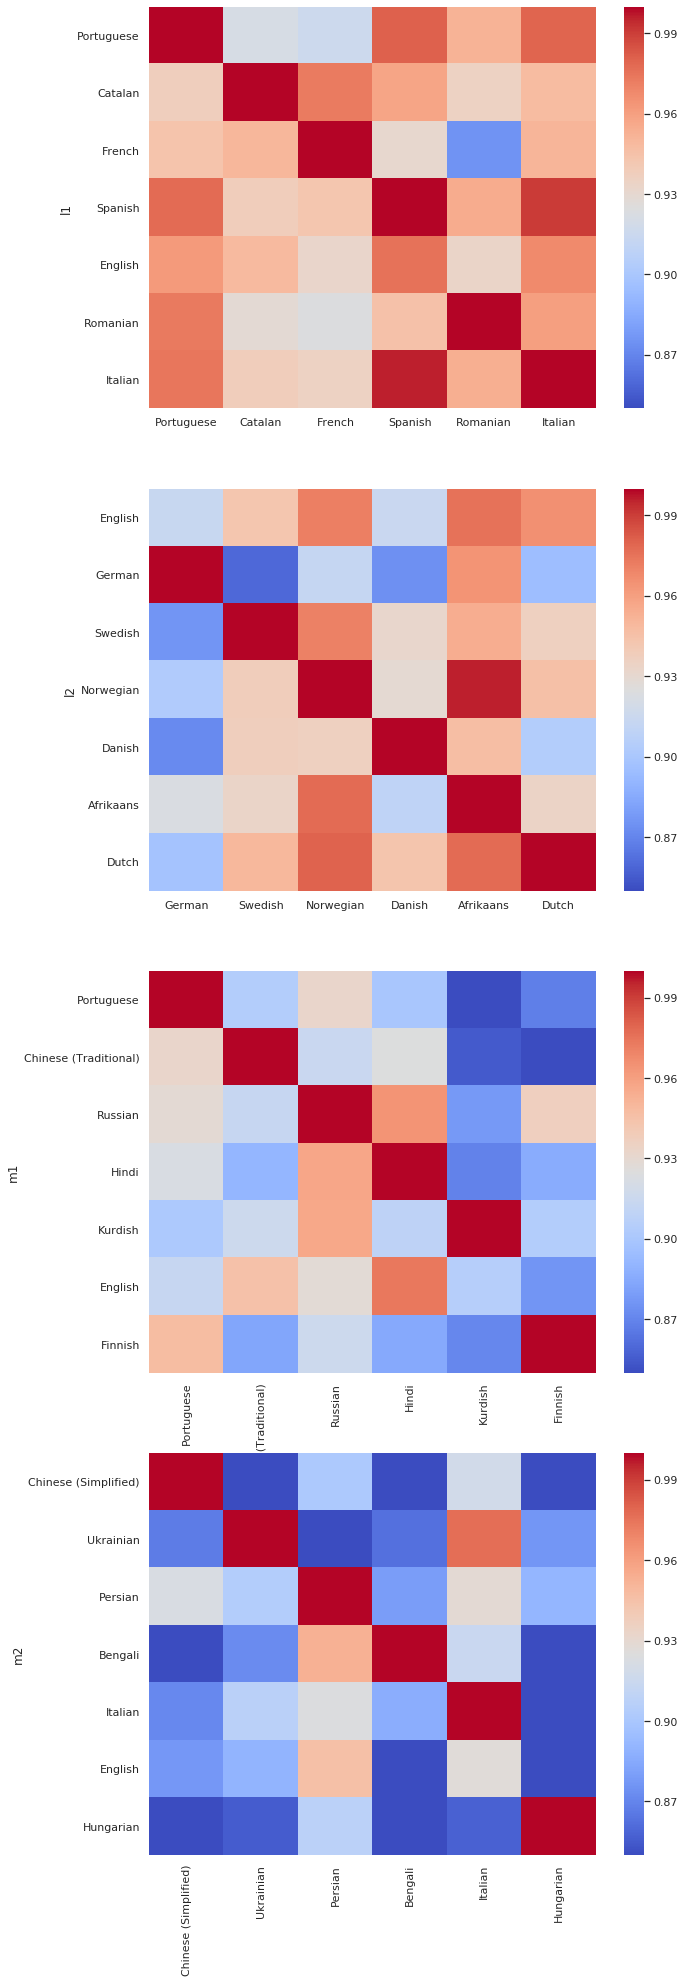

In [35]:
f, ax = plt.subplots(4,1, figsize=(10,34))
print('Mean Scores:')
print('>> l1: {0:1.4f}'.format(meanCorr(auxl1)))
print('>> l2: {0:1.4f}'.format(meanCorr(auxl2)))
print('>> m1: {0:1.4f}'.format(meanCorr(auxm1)))
print('>> m2: {0:1.4f}'.format(meanCorr(auxm2)))
sns.heatmap(auxl1, ax = ax[0], vmax = 1, vmin = 0.85, cmap = 'coolwarm')
sns.heatmap(auxl2, ax = ax[1], vmax = 1, vmin = 0.85, cmap = 'coolwarm')
sns.heatmap(auxm1, ax = ax[2], vmax = 1, vmin = 0.85, cmap = 'coolwarm')
sns.heatmap(auxm2, ax = ax[3], vmax = 1, vmin = 0.85, cmap = 'coolwarm')

## Exploring l1, l2, m1, m2, b1, b2, b3, t1 experiments

In [113]:
%%time

results = [l1_t1, l2_t1, m1_t1, m2_t1, b1_t1, b2_t1, b3_t1]
names = ['l1_t1', 'l2_t1', 'm1_t1', 'm2_t1', 'b1_t1', 'b2_t1', 'b3_t1']

res_t = Results(results, names)
res_tm = Results(results[2:], names[2:])

CPU times: user 136 ms, sys: 0 ns, total: 136 ms
Wall time: 139 ms


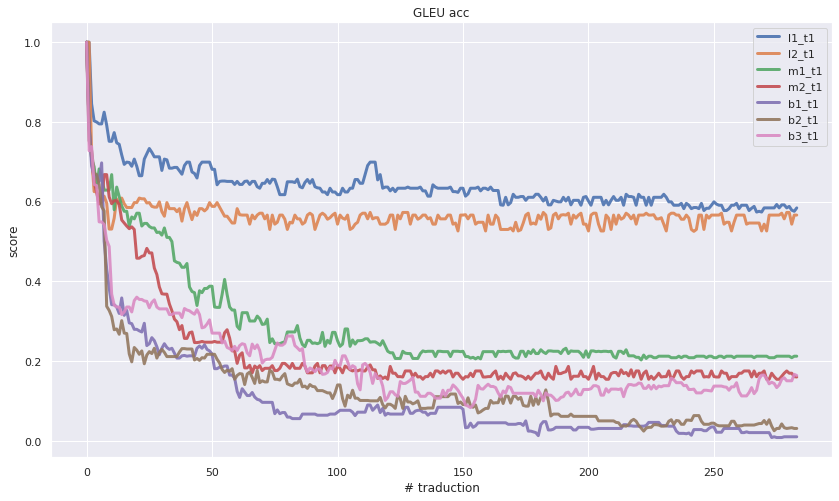

In [114]:
_ = res_t.plot('GLEU acc', showMean = False, alphaAll = 0.9)

>> alpha: 0.26052


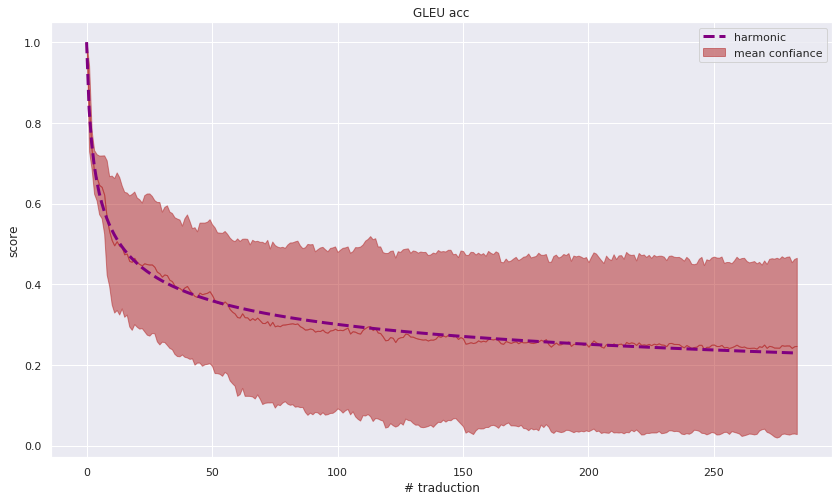

In [115]:
mean = res_t.plot('GLEU acc', showMean = False, alphaAll = 0.9, showAll=False, showHarmonic=True, fillBetween=True)

>> alpha: 0.2605210420841683


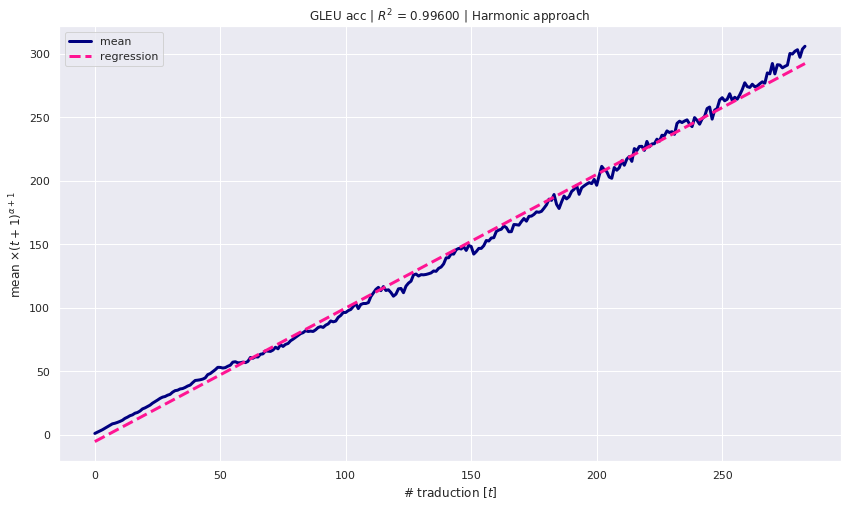

In [39]:
_ = res_t.plotRegression('GLEU acc')

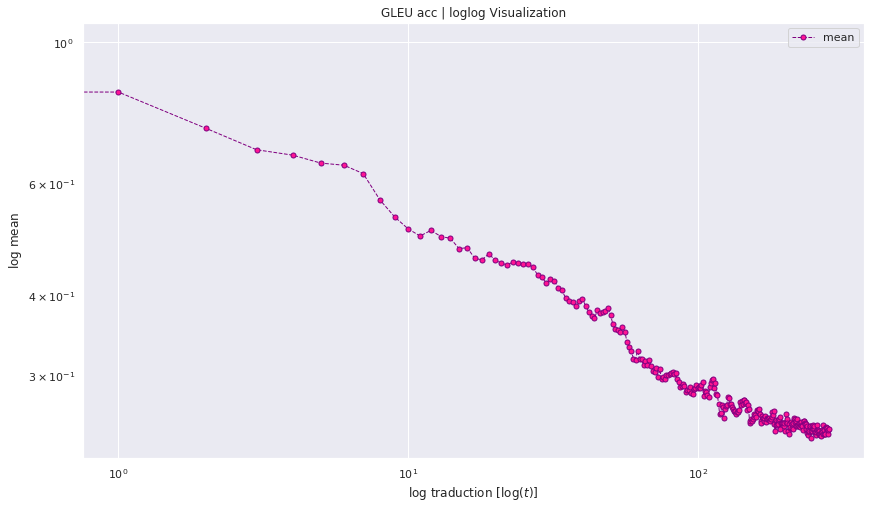

In [116]:
mean = res_t.plotLogLog('GLEU acc')

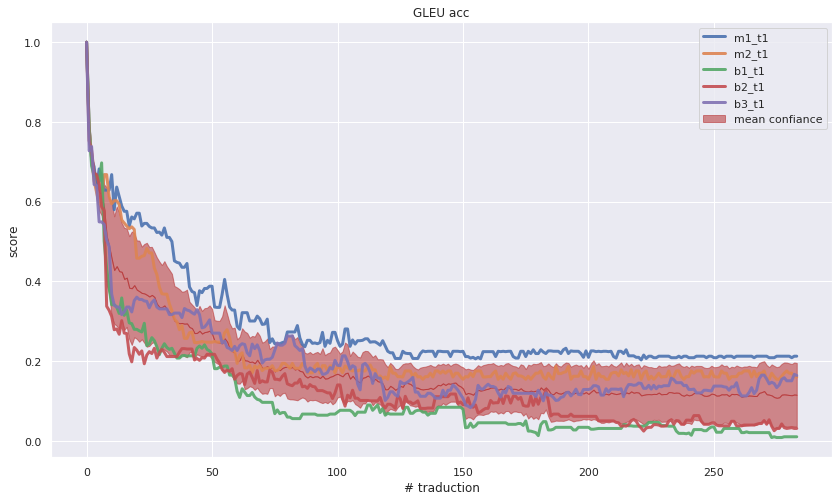

In [40]:
_ = res_tm.plot('GLEU acc', showMean = False, alphaAll = 0.9, fillBetween=True)

>> alpha: 0.37074


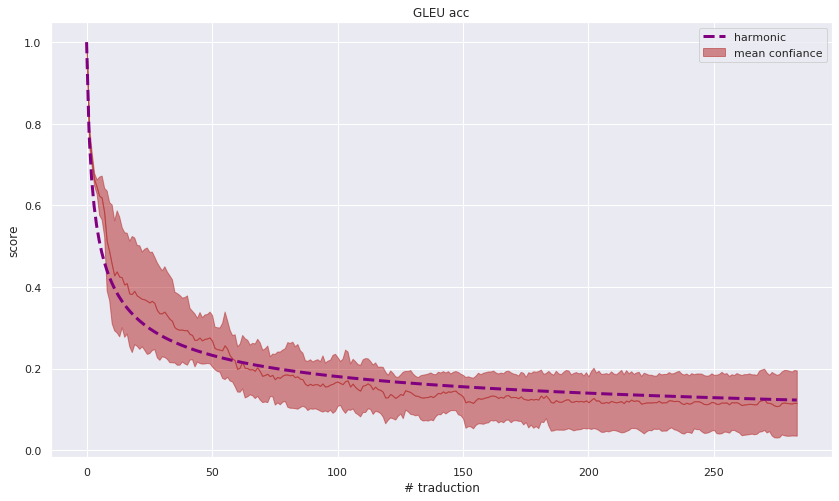

In [41]:
_ = res_tm.plot('GLEU acc', showMean = False, alphaAll = 0.9, fillBetween=True, showAll = False, showHarmonic=True)

>> alpha: 0.37074148296593185


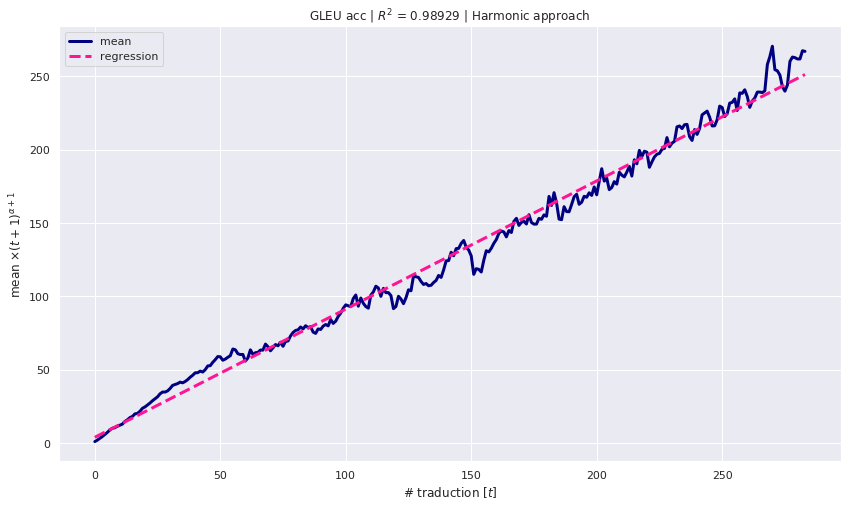

In [43]:
mean = res_tm.plotRegression('GLEU acc')

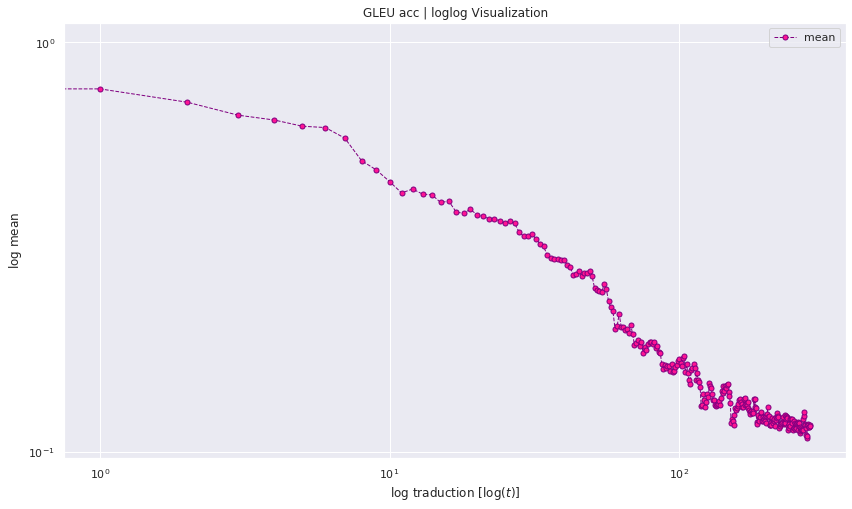

In [117]:
mean = res_tm.plotLogLog('GLEU acc')